In [217]:
import os
import pandas as pd
import numpy as np
from scipy.stats import iqr
from statsmodels.formula.api import ols
from scipy.stats import zscore
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
# Create bar plot
plt.style.use('seaborn-v0_8-poster')
#plt.style.use('seaborn-v0_8')
fontsize = 11
plt.rcParams.update({
    "font.size": fontsize,          # Global font size
    "axes.labelsize": fontsize,     # X and Y axis labels
    "axes.titlesize": fontsize,     # Title (if used)
    "xtick.labelsize": fontsize,    # X-axis tick labels
    "ytick.labelsize": fontsize,    # Y-axis tick labels
    "legend.fontsize": fontsize,    # Legend font size
})

In [253]:
project_dir = '/Users/xiaoqianxiao/projects/NARSAD'
SCR_dir = os.path.join(project_dir, 'EDR')
acquisition_file = os.path.join(SCR_dir, 'peak_stats_table-phase1.csv')
phase2and3_file = os.path.join(SCR_dir, 'peak_stats_table-phase2.3.csv')
drug_file = os.path.join(SCR_dir, 'drug_order.csv')
ECR_file = os.path.join(SCR_dir, 'ECR.csv')
df_acquisition = pd.read_csv(acquisition_file)
df_acquisition['stage'] = 'acquisition'
df_acquisition.loc[df_acquisition['stTy']=='CS+R','CS_Type'] = 'CS+_Reinf'
df_acquisition.loc[df_acquisition['stTy']=='CS+S','CS_Type'] = 'CS+_Safe'
df_acquisition.loc[df_acquisition['stTy']=='CS-','CS_Type'] = 'CS-'
print(df_acquisition.head())
df_phase2and3 = pd.read_csv(phase2and3_file)
df_phase2and3.loc[df_phase2and3['stNum']<=24,'stage'] = 'extinction'
df_phase2and3.loc[df_phase2and3['stNum']>=25,'stage'] = 'reinstatement'
df_phase2and3.loc[df_phase2and3['stTy']=='CS+R','CS_Type'] = 'CS+_Reinf'
df_phase2and3.loc[df_phase2and3['stTy']=='CS+S','CS_Type'] = 'CS+_Safe'
df_phase2and3.loc[df_phase2and3['stTy']=='CS-','CS_Type'] = 'CS-'
print(df_phase2and3.head())
df_drug = pd.read_csv(drug_file)
df_drug['group'] = df_drug['subID'].apply(lambda x: 'Patients' if x.startswith('N1') else 'Controls')
df_ECR = pd.read_csv(ECR_file)
df_behav = df_drug.merge(df_ECR, how='left', left_on='subID', right_on='subID')
df_all_acquisition = pd.merge(df_acquisition, df_behav, left_on='sid', right_on='subID', how='left')
rejTrials = df_all_acquisition[df_all_acquisition['phaBase2Peak'] < 0].index
df_all_acquisition.loc[rejTrials, 'phaBase2Peak'] = 0  # Mark non-response trials as 0
df_all_acquisition['rejTrials'] = 0
df_all_acquisition.loc[rejTrials, 'rejTrials'] = 1
df_all_acquisition = df_all_acquisition[df_all_acquisition['Gender'].isin(['Female', 'Male'])].reset_index(drop=True)
df_all_phase2and3 = pd.merge(df_phase2and3, df_behav, left_on='sid', right_on='subID', how='left')
df_all_phase2and3 = df_all_phase2and3[df_all_phase2and3['Gender'].isin(['Female', 'Male'])].reset_index(drop=True)
rejTrials = df_all_phase2and3[df_all_phase2and3['phaBase2Peak'] < 0.02].index
df_all_phase2and3.loc[rejTrials, 'phaBase2Peak'] = 0  # Mark non-response trials as 0
df_all_phase2and3['rejTrials'] = 0
df_all_phase2and3.loc[rejTrials, 'rejTrials'] = 1
df_all_phases = pd.concat([df_acquisition,df_phase2and3])
merged_df = pd.merge(df_all_phases, df_behav, left_on='sid', right_on='subID', how='left')
#get no responder as reject trials
df_all = merged_df.copy()
rejTrials = df_all[df_all['phaBase2Peak'] < 0.02].index
df_all.loc[rejTrials, 'phaBase2Peak'] = 0  # Mark non-response trials as 0
df_all['rejTrials'] = 0
df_all.loc[rejTrials, 'rejTrials'] = 1
df_all = df_all[df_all['Gender'].isin(['Female', 'Male'])].reset_index(drop=True)
#zscore
# df_all['z_phaBase2Peak'] = 1 + zscore(df_all['phaBase2Peak'])
# df_all_acquisition['z_phaBase2Peak'] = 1 + zscore(df_all_acquisition['phaBase2Peak'])
# df_all_phase2and3['z_phaBase2Peak'] = 1 + zscore(df_all_phase2and3['phaBase2Peak'])

    sid  stTy  stNum  bTime  tonBase  phaBase  phaMax  phaBase2Peak  \
0  N101  CS+R      1  710.1    0.429   -0.048  -0.030         0.019   
1  N101  CS+S      2  729.1    0.776   -0.069  -0.016         0.052   
2  N101   CS-      3  749.2    0.875   -0.005   0.001         0.006   
3  N101  CS+R      4  767.2    0.738   -0.020  -0.019         0.001   
4  N101  CS+S      5  786.2    0.881   -0.171  -0.007         0.164   

   phaPeakLatency  phaMinLatency  USPeakLatency  phaMaxUS  USminLatency  \
0           712.2          710.2          720.5  0.218286         717.5   
1           734.4          732.2          739.3  0.115014         736.5   
2           753.8          749.7          760.2  0.000766         757.3   
3           769.8          769.2          777.3  0.081659         774.5   
4           791.7          789.6          796.1  0.256895         793.4   

   phaMinUS  USbase2peak  bad        stage    CS_Type  
0 -0.194254        0.413    0  acquisition  CS+_Reinf  
1 -0.06618

In [221]:
# Check existing of miss-data subjects
# generate df_filtered with only subjects have all trails 
# Define expected structure
conditions = 3  # e.g., CS types
stages = 3     # 'acquisition', 'extinction', 'reinstatement'
trials_per_cond_stage = 8
expected_rows = conditions * stages * trials_per_cond_stage  # 3 * 3 * 8 = 72

# Step 1: Count rows per sid
sid_counts = df_all.groupby('sid').size()
print("Row counts per sid:")
print(sid_counts)

# Step 2: Identify sids with exactly 72 rows
valid_sids = sid_counts[sid_counts == expected_rows].index
print(f"\nNumber of sids with exactly {expected_rows} rows: {len(valid_sids)}")
print("Valid sids:", valid_sids.tolist())

# Step 3: Filter df_final to keep only sids with 72 rows
df_filtered = df_all[df_all['sid'].isin(valid_sids)].copy()
print(f"\nFiltered DataFrame size: {df_filtered.shape}")
print("Unique sids in filtered data:", df_filtered['sid'].nunique())

# Verify structure (assuming a condition column exists, e.g., 'CS_Type')
if 'CS_Type' in df_filtered.columns:  # Replace 'CS_Type' with your condition column name if different
    structure_check = df_filtered.groupby(['sid', 'stage', 'CS_Type']).size()
    print("\nTrial counts per sid, stage, and condition in filtered data:")
    print(structure_check)
else:
    structure_check = df_filtered.groupby(['sid', 'stage']).size()
    print("\nTrial counts per sid and stage in filtered data (assuming 24 trials/stage):")
    print(structure_check)

# Step 4: Identify and summarize sids with fewer than 72 rows
invalid_sids = sid_counts[sid_counts < expected_rows].index
print(f"\nNumber of sids with fewer than {expected_rows} rows: {len(invalid_sids)}")
print("SIDs with fewer than 72 rows (sid, stage, CS_Type, trial count):")

# Filter invalid sids and group by sid, stage, CS_Type to count trials
if 'CS_Type' in df_filtered.columns:
    df_invalid = df_filtered[df_filtered['sid'].isin(invalid_sids)].groupby(['sid', 'stage', 'CS_Type']).size().reset_index(name='trial_count')
    # Print in requested format
    for index, row in df_invalid.iterrows():
        print(f"sid: {row['sid']}, stage: {row['stage']}, CS_Type: {row['CS_Type']}, trials: {row['trial_count']}")
else:
    df_invalid = df_filtered[df_filtered['sid'].isin(invalid_sids)].groupby(['sid', 'stage']).size().reset_index(name='trial_count')
    # Print without CS_Type if not present
    for index, row in df_invalid.iterrows():
        print(f"sid: {row['sid']}, stage: {row['stage']}, trials: {row['trial_count']}")

print(f"Total rows for invalid sids: {df_all[df_all['sid'].isin(invalid_sids)].shape[0]}")

Row counts per sid:
sid
N101    72
N102    24
N103    72
N104    72
N105    72
        ..
N255    72
N257    72
N258    72
N259    72
N260    72
Length: 103, dtype: int64

Number of sids with exactly 72 rows: 101
Valid sids: ['N101', 'N103', 'N104', 'N105', 'N106', 'N108', 'N109', 'N110', 'N111', 'N112', 'N113', 'N114', 'N115', 'N117', 'N118', 'N121', 'N122', 'N123', 'N124', 'N125', 'N127', 'N128', 'N129', 'N130', 'N131', 'N132', 'N133', 'N134', 'N135', 'N136', 'N137', 'N138', 'N141', 'N142', 'N143', 'N144', 'N145', 'N146', 'N147', 'N148', 'N149', 'N150', 'N151', 'N153', 'N154', 'N155', 'N156', 'N157', 'N158', 'N201', 'N202', 'N203', 'N204', 'N206', 'N207', 'N209', 'N210', 'N211', 'N212', 'N213', 'N214', 'N215', 'N216', 'N217', 'N219', 'N220', 'N221', 'N222', 'N224', 'N225', 'N226', 'N227', 'N228', 'N230', 'N231', 'N232', 'N233', 'N234', 'N235', 'N236', 'N237', 'N238', 'N240', 'N241', 'N242', 'N243', 'N244', 'N246', 'N247', 'N248', 'N249', 'N250', 'N251', 'N252', 'N253', 'N254', 'N255'

In [222]:
# generate df for only responders
df_responder = df_filtered.loc[df_filtered['rejTrials']==0].copy()
df_responder_acquisition = df_all_acquisition.loc[df_all_acquisition['rejTrials']==0].copy()
df_responder_phase2and3 = df_all_phase2and3.loc[df_all_phase2and3['rejTrials']==0].copy()

In [223]:
## Functions for outliers
# Function to detect outliers using IQR (Tukey's Fences)
# Function to detect outliers using IQR (Tukey's Fences)
def count_outliers_iqr(series, k=3):
    q1 = series.quantile(0.25)
    q3 = series.quantile(0.75)
    iqr_val = q3 - q1
    lower_bound = q1 - k * iqr_val
    upper_bound = q3 + k * iqr_val
    outliers = (series < lower_bound) | (series > upper_bound)
    return outliers  # Return boolean Series

# Function to detect outliers using Modified Z-Score (MAD)
def count_outliers_mad(series, threshold=4):
    median = series.median()
    mad = np.median(np.abs(series - median))
    if mad == 0:
        print(f"Warning: MAD is zero for this series, falling back to IQR (k={k})")
        return count_outliers_iqr(series, k=3)
    z_m = 0.6745 * (series - median) / mad
    outliers = abs(z_m) > threshold
    return outliers  # Return boolean Series

In [224]:
#outliers for df_filtered
# Define stages and groups
stages = ['acquisition', 'extinction', 'reinstatement']
groups = ['Patients', 'Controls']

# Get all unique group-stage combinations
group_stage_pairs = [(group, stage) for group in groups for stage in stages]

# Initialize two outlier flag columns in df_responder
df_responder['outlier_flag_IQR'] = None  # Flag for IQR outliers
df_responder['outlier_flag_MAD'] = None  # Flag for MAD outliers

# Initialize a list to store outlier information (for CSV export)
outlier_info = []

# Iterate over each group-stage combination to flag outliers
for group, stage in group_stage_pairs:
    # Filter data for the current group and stage (case-insensitive for stage)
    subset_data = df_responder[(df_responder['group'] == group) & 
                              (df_responder['stage'].str.lower() == stage.lower())]
    
    # Diagnostic: Check data availability and sample
    print(f"\nChecking data for {stage.capitalize()} - {group}:")
    print(f"  Total rows: {len(subset_data)}")
    print(f"  phaBase2Peak NaN count: {subset_data['phaBase2Peak'].isna().sum()}")
    print(f"  phaBase2Peak non-NaN count: {subset_data['phaBase2Peak'].count()}")
    print(f"  Sample of phaBase2Peak values: {subset_data['phaBase2Peak'].head().tolist()}")
    print(f"  Full phaBase2Peak description:\n{subset_data['phaBase2Peak'].describe()}")

    # Compute descriptive statistics
    group_data = subset_data['phaBase2Peak']
    if group_data.empty or group_data.isna().all():
        print(f"Descriptive Statistics for {stage.capitalize()} - {group}: No data")
        continue
    
    stats = {
        'N': group_data.count(),           # Number of non-NaN observations
        'Min': group_data.min(),
        'Max': group_data.max(),
        'Mean': group_data.mean(),
        'Median': group_data.median(),
        'IQR': iqr(group_data),
        'Outliers_IQR': count_outliers_iqr(group_data, k=3).sum(),  # Count of IQR outliers
        'Outliers_MAD': count_outliers_mad(group_data, threshold=4).sum(),  # Count of MAD outliers
        'NaN Count': group_data.isna().sum()
    }
    
    # Create a DataFrame for the table (single row)
    stats_df = pd.DataFrame([stats], index=[f"{group}"])
    # Format numeric columns to 4 decimal places
    for col in ['Min', 'Max', 'Mean', 'Median', 'IQR']:
        stats_df[col] = stats_df[col].map('{:.4f}'.format)
    
    print(f"\nDescriptive Statistics for {stage.capitalize()} - {group}:")
    print(stats_df.to_string())

    # Detect outliers and flag them in df_responder
    outliers_iqr = count_outliers_iqr(group_data, k=3)
    outliers_mad = count_outliers_mad(group_data, threshold=4)
    
    print(f"  IQR outliers count (k=3): {outliers_iqr.sum()}")
    print(f"  MAD outliers count (threshold=4): {outliers_mad.sum()}")

    # Flag outliers in df_responder
    mask = (df_responder['group'] == group) & (df_responder['stage'].str.lower() == stage.lower())
    df_responder.loc[mask & outliers_iqr, 'outlier_flag_IQR'] = 'Outlier'
    df_responder.loc[mask & ~outliers_iqr, 'outlier_flag_IQR'] = None  # Explicitly set non-outliers to None
    df_responder.loc[mask & outliers_mad, 'outlier_flag_MAD'] = 'Outlier'
    df_responder.loc[mask & ~outliers_mad, 'outlier_flag_MAD'] = None  # Explicitly set non-outliers to None


Checking data for Acquisition - Patients:
  Total rows: 355
  phaBase2Peak NaN count: 0
  phaBase2Peak non-NaN count: 355
  Sample of phaBase2Peak values: [0.052, 0.164, 0.046, 0.045, 0.059]
  Full phaBase2Peak description:
count    355.00000
mean       0.13711
std        0.14465
min        0.02000
25%        0.03850
50%        0.08400
75%        0.18050
max        0.95600
Name: phaBase2Peak, dtype: float64

Descriptive Statistics for Acquisition - Patients:
            N     Min     Max    Mean  Median     IQR  Outliers_IQR  Outliers_MAD  NaN Count
Patients  355  0.0200  0.9560  0.1371  0.0840  0.1420             6            18          0
  IQR outliers count (k=3): 6
  MAD outliers count (threshold=4): 18

Checking data for Extinction - Patients:
  Total rows: 748
  phaBase2Peak NaN count: 0
  phaBase2Peak non-NaN count: 748
  Sample of phaBase2Peak values: [0.023, 0.037, 0.02, 0.103, 0.031]
  Full phaBase2Peak description:
count    748.000000
mean       0.049068
std        0.15042

In [225]:
# label outliers for acquisition
# Define stages and groups
stages = ['acquisition']
groups = ['Patients', 'Controls']

# Get all unique group-stage combinations
group_stage_pairs = [(group, stage) for group in groups for stage in stages]

# Initialize two outlier flag columns in df_responder
df_responder_acquisition['outlier_flag_IQR'] = None
df_responder_acquisition['outlier_flag_MAD'] = None


# Initialize a list to store outlier information (for CSV export)
outlier_info = []

# Iterate over each group-stage combination to flag outliers
for group, stage in group_stage_pairs:
    # Filter data for the current group and stage (case-insensitive for stage)
    subset_data = df_responder_acquisition[(df_responder_acquisition['group'] == group) & 
                              (df_responder_acquisition['stage'].str.lower() == stage.lower())]
    
    # Diagnostic: Check data availability and sample
    print(f"\nChecking data for {stage.capitalize()} - {group}:")
    print(f"  Total rows: {len(subset_data)}")
    print(f"  phaBase2Peak NaN count: {subset_data['phaBase2Peak'].isna().sum()}")
    print(f"  phaBase2Peak non-NaN count: {subset_data['phaBase2Peak'].count()}")
    print(f"  Sample of phaBase2Peak values: {subset_data['phaBase2Peak'].head().tolist()}")
    print(f"  Full phaBase2Peak description:\n{subset_data['phaBase2Peak'].describe()}")

    # Compute descriptive statistics
    group_data = subset_data['phaBase2Peak']
    if group_data.empty or group_data.isna().all():
        print(f"Descriptive Statistics for {stage.capitalize()} - {group}: No data")
        continue
    
    stats = {
        'N': group_data.count(),           # Number of non-NaN observations
        'Min': group_data.min(),
        'Max': group_data.max(),
        'Mean': group_data.mean(),
        'Median': group_data.median(),
        'IQR': iqr(group_data),
        'Outliers_IQR': count_outliers_iqr(group_data, k=3).sum(),  # Count of IQR outliers
        'Outliers_MAD': count_outliers_mad(group_data, threshold=4).sum(),  # Count of MAD outliers
        'NaN Count': group_data.isna().sum()
    }
    
    # Create a DataFrame for the table (single row)
    stats_df = pd.DataFrame([stats], index=[f"{group}"])
    # Format numeric columns to 4 decimal places
    for col in ['Min', 'Max', 'Mean', 'Median', 'IQR']:
        stats_df[col] = stats_df[col].map('{:.4f}'.format)
    
    print(f"\nDescriptive Statistics for {stage.capitalize()} - {group}:")
    print(stats_df.to_string())

    # Detect outliers and flag them in df_responder
    outliers_iqr = count_outliers_iqr(group_data, k=3)
    outliers_mad = count_outliers_mad(group_data, threshold=4)
    

    # Flag outliers in df_responder
    mask = (df_responder_acquisition['group'] == group) & (df_responder_acquisition['stage'].str.lower() == stage.lower())
    df_responder_acquisition.loc[mask & outliers_iqr, 'outlier_flag_IQR'] = 'Outlier'
    df_responder_acquisition.loc[mask & ~outliers_iqr, 'outlier_flag_IQR'] = None  # Explicitly set non-outliers to None
    df_responder_acquisition.loc[mask & outliers_mad, 'outlier_flag_MAD'] = 'Outlier'
    df_responder_acquisition.loc[mask & ~outliers_mad, 'outlier_flag_MAD'] = None  # Explicitly set non-outliers to None


Checking data for Acquisition - Patients:
  Total rows: 1003
  phaBase2Peak NaN count: 0
  phaBase2Peak non-NaN count: 1003
  Sample of phaBase2Peak values: [0.019, 0.052, 0.006, 0.001, 0.164]
  Full phaBase2Peak description:
count    1003.000000
mean        0.051305
std         0.106982
min        -0.000000
25%         0.002000
50%         0.007000
75%         0.043000
max         0.956000
Name: phaBase2Peak, dtype: float64

Descriptive Statistics for Acquisition - Patients:
             N      Min     Max    Mean  Median     IQR  Outliers_IQR  Outliers_MAD  NaN Count
Patients  1003  -0.0000  0.9560  0.0513  0.0070  0.0410            98           233          0

Checking data for Acquisition - Controls:
  Total rows: 1106
  phaBase2Peak NaN count: 0
  phaBase2Peak non-NaN count: 1106
  Sample of phaBase2Peak values: [0.188, 0.064, 0.234, 0.141, 0.181]
  Full phaBase2Peak description:
count    1106.000000
mean        0.081052
std         0.164470
min        -0.000000
25%         0.002

In [226]:
# label outliers for extinction and reinstatement
# Define stages and groups
stages = ['extinction', 'reinstatement']
groups = ['Patients', 'Controls']

# Get all unique group-stage combinations
group_stage_pairs = [(group, stage) for group in groups for stage in stages]

# Initialize two outlier flag columns in df_responder
# df_responder_acquisition['outlier_flag_IQR'] = None
# df_responder_acquisition['outlier_flag_MAD'] = None
df_responder_phase2and3['outlier_flag_IQR'] = None
df_responder_phase2and3['outlier_flag_MAD'] = None

# Initialize a list to store outlier information (for CSV export)
outlier_info = []

# Iterate over each group-stage combination to flag outliers
for group, stage in group_stage_pairs:
    # Filter data for the current group and stage (case-insensitive for stage)
    subset_data = df_responder_phase2and3[(df_responder_phase2and3['group'] == group) & 
                              (df_responder_phase2and3['stage'].str.lower() == stage.lower())]
    
    # Diagnostic: Check data availability and sample
    print(f"\nChecking data for {stage.capitalize()} - {group}:")
    print(f"  Total rows: {len(subset_data)}")
    print(f"  phaBase2Peak NaN count: {subset_data['phaBase2Peak'].isna().sum()}")
    print(f"  phaBase2Peak non-NaN count: {subset_data['phaBase2Peak'].count()}")
    print(f"  Sample of phaBase2Peak values: {subset_data['phaBase2Peak'].head().tolist()}")
    print(f"  Full phaBase2Peak description:\n{subset_data['phaBase2Peak'].describe()}")

    # Compute descriptive statistics
    group_data = subset_data['phaBase2Peak']
    if group_data.empty or group_data.isna().all():
        print(f"Descriptive Statistics for {stage.capitalize()} - {group}: No data")
        continue
    
    stats = {
        'N': group_data.count(),           # Number of non-NaN observations
        'Min': group_data.min(),
        'Max': group_data.max(),
        'Mean': group_data.mean(),
        'Median': group_data.median(),
        'IQR': iqr(group_data),
        'Outliers_IQR': count_outliers_iqr(group_data, k=3).sum(),  # Count of IQR outliers
        'Outliers_MAD': count_outliers_mad(group_data, threshold=4).sum(),  # Count of MAD outliers
        'NaN Count': group_data.isna().sum()
    }
    
    # Create a DataFrame for the table (single row)
    stats_df = pd.DataFrame([stats], index=[f"{group}"])
    # Format numeric columns to 4 decimal places
    for col in ['Min', 'Max', 'Mean', 'Median', 'IQR']:
        stats_df[col] = stats_df[col].map('{:.4f}'.format)
    
    print(f"\nDescriptive Statistics for {stage.capitalize()} - {group}:")
    print(stats_df.to_string())

    # Detect outliers and flag them in df_responder
    outliers_iqr = count_outliers_iqr(group_data, k=3)
    outliers_mad = count_outliers_mad(group_data, threshold=4)
    

    # Flag outliers in df_responder
    mask = (df_responder_phase2and3['group'] == group) & (df_responder_phase2and3['stage'].str.lower() == stage.lower())
    df_responder_phase2and3.loc[mask & outliers_iqr, 'outlier_flag_IQR'] = 'Outlier'
    df_responder_phase2and3.loc[mask & ~outliers_iqr, 'outlier_flag_IQR'] = None  # Explicitly set non-outliers to None
    df_responder_phase2and3.loc[mask & outliers_mad, 'outlier_flag_MAD'] = 'Outlier'
    df_responder_phase2and3.loc[mask & ~outliers_mad, 'outlier_flag_MAD'] = None  # Explicitly set non-outliers to None


Checking data for Extinction - Patients:
  Total rows: 748
  phaBase2Peak NaN count: 0
  phaBase2Peak non-NaN count: 748
  Sample of phaBase2Peak values: [0.023, 0.037, 0.02, 0.103, 0.031]
  Full phaBase2Peak description:
count    748.000000
mean       0.049068
std        0.150420
min        0.020000
25%        0.022750
50%        0.026000
75%        0.040000
max        3.808000
Name: phaBase2Peak, dtype: float64

Descriptive Statistics for Extinction - Patients:
            N     Min     Max    Mean  Median     IQR  Outliers_IQR  Outliers_MAD  NaN Count
Patients  748  0.0200  3.8080  0.0491  0.0260  0.0173            57           109          0

Checking data for Reinstatement - Patients:
  Total rows: 876
  phaBase2Peak NaN count: 0
  phaBase2Peak non-NaN count: 876
  Sample of phaBase2Peak values: [0.029, 0.023, 0.022, 0.027, 0.026]
  Full phaBase2Peak description:
count    876.000000
mean       0.078492
std        0.143740
min        0.020000
25%        0.024000
50%        0.03100

In [263]:
# generate df without outliers
df_cleaned = df_responder.loc[df_responder['outlier_flag_IQR'] != 'Outlier'].copy()
print(df_cleaned.shape)
df_cleaned_acquisition = df_responder_acquisition.loc[df_responder_acquisition['outlier_flag_IQR'] != 'Outlier'].copy()
df_cleaned_phase2and3 = df_responder_phase2and3.loc[df_responder_phase2and3['outlier_flag_IQR'] != 'Outlier'].copy()

                            Mixed Linear Model Regression Results
Model:                        MixedLM            Dependent Variable:            z_phaBase2Peak
No. Observations:             1936               Method:                        REML          
No. Groups:                   103                Scale:                         0.0909        
Min. group size:              4                  Log-Likelihood:                -600.6887     
Max. group size:              24                 Converged:                     Yes           
Mean group size:              18.8                                                            
----------------------------------------------------------------------------------------------
                                                    Coef.  Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------------------------------------------------
Intercept                                            0.967    0.127  7.603 0.00

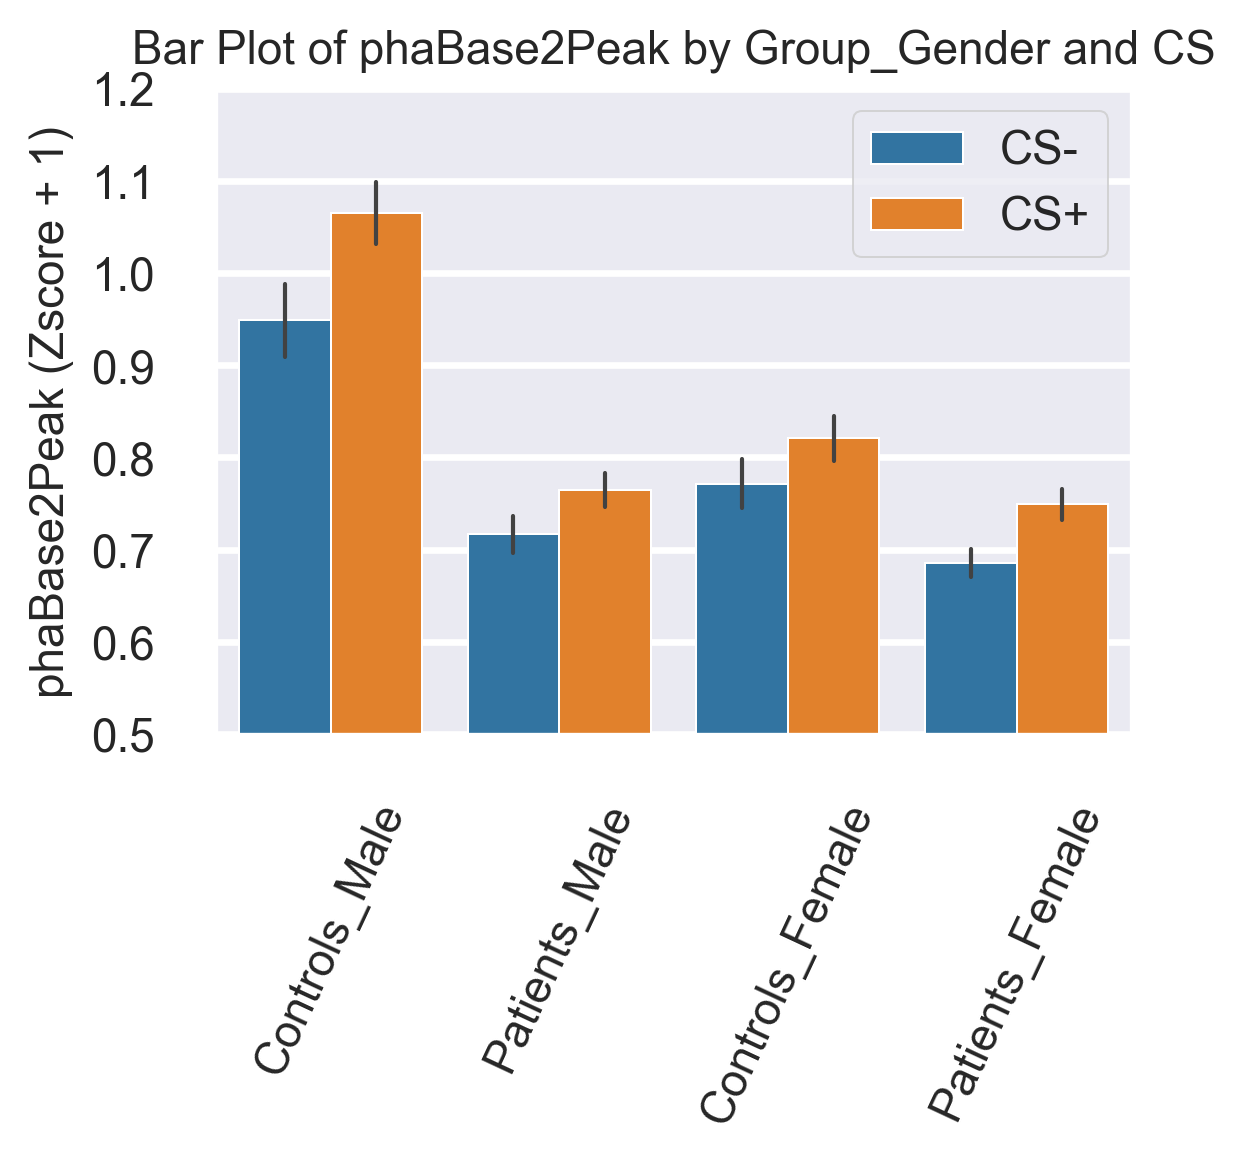

In [238]:
#df = df_all_acquisition.copy()
#df = df_responder_acquisition.copy()
df = df_cleaned_acquisition.copy()
df['Avoidance_centered'] = df['Avoidance'] - df['Avoidance'].mean()
df['Group_Gender'] = df['group'] + '_' + df['Gender']
df['CS'] = 'CS+'  # Default to 'CS+'
df.loc[df['CS_Type'] == 'CS-', 'CS'] = 'CS-'  # Modify only where CS_Type is 'CS-'
x_order = ['Controls_Male', 
           'Patients_Male',
           'Controls_Female',
           'Patients_Female']  # Modify drug names if different

df[['group', 'CS', 'Gender']] = df[['group', 'CS', 'Gender']].astype('category')
model = smf.mixedlm(
    formula="z_phaBase2Peak ~ C(group) * C(CS) * C(Gender) + Avoidance_centered + demo_age",
    data=df,
    groups=df['sid']
)
result = model.fit()
print(result.summary())
#
fig, ax = plt.subplots(figsize=(4, 4), dpi=300)
sns.barplot(
        data=df,
        x='Group_Gender',
        y='z_phaBase2Peak',
        hue='CS',
        hue_order=['CS-', 'CS+'],
        order=x_order,
        errorbar='se',
        err_kws={'linewidth': 1},
        ax=ax
    )

plt.xlabel('')
plt.ylabel('phaBase2Peak (Zscore + 1)')
plt.title('Bar Plot of phaBase2Peak by Group_Gender and CS')
plt.legend(title='', fontsize=fontsize)
plt.xticks(rotation=65)
ax.set_ylim(0.5, 1.2)
plt.tight_layout()
plt.show()

# Significant Main Effects:
CS: CS+ increased z_phaBase2Peak by 0.060 SD (p = 0.027) compared to CS-.<br /> 
Gender: Males have a 0.288 SD higher z_phaBase2Peak (p = 0.001) than Females.
# Significant Interaction:
group:Gender (p = 0.039): The male greater response (higher z_phaBase2Peak) is reduced in Patients (-0.257 SD), suggesting gender differences depend on group status.

In [237]:
# simpler model
model = smf.mixedlm(
    formula="z_phaBase2Peak ~ C(group) * C(CS) * C(Gender)",
    data=df,
    groups=df['sid']
)
result = model.fit()
print(result.summary())

                            Mixed Linear Model Regression Results
Model:                        MixedLM            Dependent Variable:            z_phaBase2Peak
No. Observations:             1936               Method:                        REML          
No. Groups:                   103                Scale:                         0.0909        
Min. group size:              4                  Log-Likelihood:                -600.6887     
Max. group size:              24                 Converged:                     Yes           
Mean group size:              18.8                                                            
----------------------------------------------------------------------------------------------
                                                    Coef.  Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------------------------------------------------
Intercept                                            0.967    0.127  7.603 0.00

In [249]:
df['CS_Type'].unique()

['CS-', 'CS+_Reinf', 'CS+_Safe']
Categories (3, object): ['CS+_Reinf', 'CS+_Safe', 'CS-']

                                 Mixed Linear Model Regression Results
Model:                            MixedLM               Dependent Variable:               z_phaBase2Peak
No. Observations:                 2331                  Method:                           REML          
No. Groups:                       101                   Scale:                            0.4114        
Min. group size:                  6                     Log-Likelihood:                   -2432.9977    
Max. group size:                  24                    Converged:                        Yes           
Mean group size:                  23.1                                                                  
--------------------------------------------------------------------------------------------------------
                                                              Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------------------------------------------

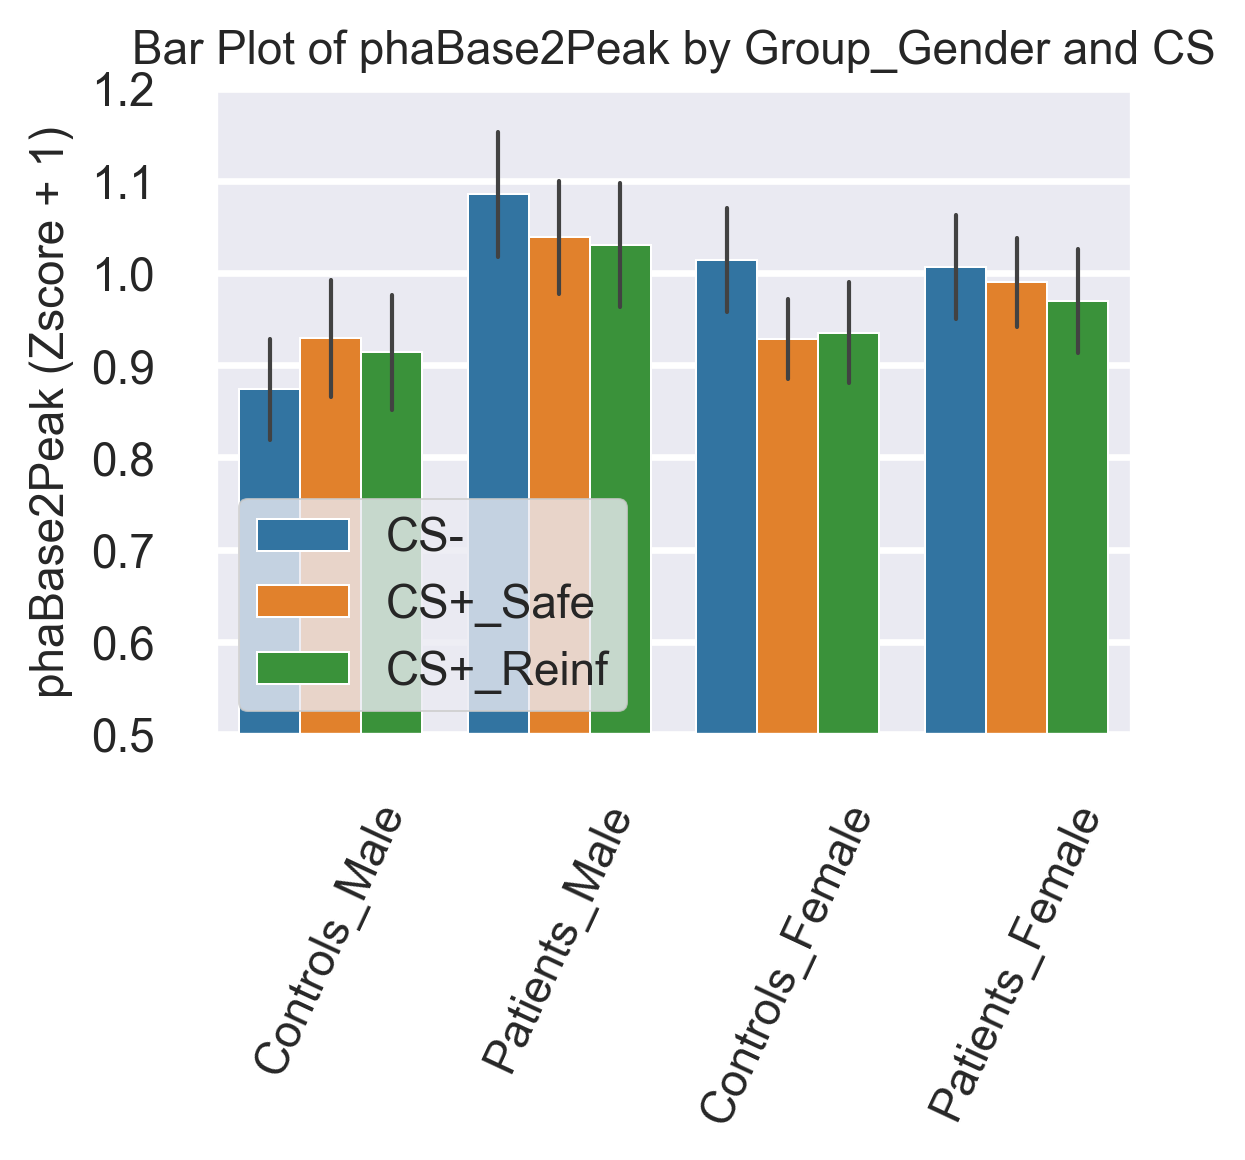

In [267]:
## extinction
#df = df_all_phase2and3.loc[df_all_phase2and3['stage']=='extinction'].copy()
#df = df_responder_phase2and3.loc[df_responder_phase2and3['stage']=='extinction'].copy()
df = df_cleaned_phase2and3.loc[df_responder_phase2and3['stage']=='extinction'].copy()
df['Avoidance_centered'] = df['Avoidance'] - df['Avoidance'].mean()
df['Group_Gender'] = df['group'] + '_' + df['Gender']
x_order = ['Controls_Male', 
           'Patients_Male',
           'Controls_Female',
           'Patients_Female']  # Modify drug names if different

df[['group', 'CS_Type', 'Gender']] = df[['group', 'CS_Type', 'Gender']].astype('category')
model = smf.mixedlm(
    formula="z_phaBase2Peak ~ C(group) * C(CS_Type) * C(Gender) + Avoidance_centered + demo_age",
    data=df,
    groups=df['sid']
)
result = model.fit()
print(result.summary())
#
fig, ax = plt.subplots(figsize=(4, 4), dpi=300)
sns.barplot(
        data=df,
        x='Group_Gender',
        y='z_phaBase2Peak',
        hue='CS_Type',
        hue_order=['CS-', 'CS+_Safe', 'CS+_Reinf'],
        order=x_order,
        errorbar='se',
        err_kws={'linewidth': 1},
        ax=ax
    )

plt.xlabel('')
plt.ylabel('phaBase2Peak (Zscore + 1)')
plt.title('Bar Plot of phaBase2Peak by Group_Gender and CS')
plt.legend(title='', fontsize=fontsize)
plt.xticks(rotation=65)
ax.set_ylim(0.5, 1.2)
plt.tight_layout()
plt.show()

In [146]:
# fixed effect model for extinction
df = df_cleaned_phase2and3.loc[df_cleaned_phase2and3['stage']=='extinction'].copy()
df['phaBase2Peak_log'] = np.log1p(df['phaBase2Peak'])
df['phaBase2Peak_sqrt'] = np.sqrt(df['phaBase2Peak'])
df_aggregated = df.groupby(['sid', 'group','Drug','CS_Type'])[['phaBase2Peak', 'Avoidance', 'demo_age']].mean().reset_index()
# Handle gender (categorical, consistent within sid)
df_aggregated['Gender'] = df.groupby(['sid', 'group','Drug','CS_Type'])['Gender'].first().reset_index(drop=True)
df_aggregated['Avoidance_centered'] = df_aggregated['Avoidance'] - df_aggregated['Avoidance'].mean()

model_ols = ols("phaBase2Peak ~ C(group) * C(CS_Type) * C(Gender) * C(Drug) + Avoidance_centered", data=df_aggregated)
result_ols = model_ols.fit()
print("\nFixed-Effects OLS Results C(group) * C(CS_Type) * C(Gender) * C(Drug) + Avoidance_centered):")
print(result_ols.summary())
fig, ax = plt.subplots(figsize=(4, 4), dpi=300)
sns.barplot(
        data=df,
        x='Group_Gender',
        y='phaBase2Peak',
        hue='CS',
        order=x_order,
        errorbar='se',
        err_kws={'linewidth': 1},
        ax=ax
    )


# Labels and formatting
plt.xlabel('')
plt.ylabel('phaBase2Peak')
plt.title('Bar Plot of phaBase2Peak by Group_Gender and CS')
# Customize the legend position
plt.legend(title='', fontsize=fontsize)
plt.xticks(rotation=65)
plt.tight_layout()
plt.show()


Fixed-Effects OLS Results C(group) * C(CS_Type) * C(Gender) * C(Drug) + Avoidance_centered):
                            OLS Regression Results                            
Dep. Variable:           phaBase2Peak   R-squared:                       0.038
Model:                            OLS   Adj. R-squared:                 -0.045
Method:                 Least Squares   F-statistic:                    0.4570
Date:                Thu, 06 Mar 2025   Prob (F-statistic):              0.988
Time:                        16:23:13   Log-Likelihood:                 1021.3
No. Observations:                 301   AIC:                            -1993.
Df Residuals:                     276   BIC:                            -1900.
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
                                                                                       coef    std err          t   

In [148]:
# fixed effect model for reinstatement
df = df_cleaned_phase2and3.loc[df_cleaned_phase2and3['stage']=='reinstatement'].copy()
df['phaBase2Peak_log'] = np.log1p(df['phaBase2Peak'])
df['phaBase2Peak_sqrt'] = np.sqrt(df['phaBase2Peak'])
df_aggregated = df.groupby(['sid', 'group','Drug','CS_Type'])[['phaBase2Peak', 'Avoidance', 'demo_age']].mean().reset_index()
# Handle gender (categorical, consistent within sid)
df_aggregated['Gender'] = df.groupby(['sid', 'group','Drug','CS_Type'])['Gender'].first().reset_index(drop=True)
df_aggregated['Avoidance_centered'] = df_aggregated['Avoidance'] - df_aggregated['Avoidance'].mean()

model_ols = ols("phaBase2Peak ~ C(group) * C(CS_Type) * C(Gender) * C(Drug) + Avoidance_centered", data=df_aggregated)
result_ols = model_ols.fit()
print("\nFixed-Effects OLS Results C(group) * C(CS_Type) * C(Gender) * C(Drug) + Avoidance_centered):")
print(result_ols.summary())


Fixed-Effects OLS Results C(group) * C(CS_Type) * C(Gender) * C(Drug) + Avoidance_centered):
                            OLS Regression Results                            
Dep. Variable:           phaBase2Peak   R-squared:                       0.064
Model:                            OLS   Adj. R-squared:                 -0.018
Method:                 Least Squares   F-statistic:                    0.7801
Date:                Thu, 06 Mar 2025   Prob (F-statistic):              0.761
Time:                        16:24:40   Log-Likelihood:                 879.85
No. Observations:                 301   AIC:                            -1710.
Df Residuals:                     276   BIC:                            -1617.
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
                                                                                       coef    std err          t   

##### little could be explained within extinction and reinstatement stage, respectively.
##### move on with the effect of stage

In [149]:
# stage effect: aquision vs. extinction
df = df_cleaned.loc[df_cleaned['stage'] != 'reinstatement'].copy()
df['phaBase2Peak_log'] = np.log1p(df['phaBase2Peak'])
df['phaBase2Peak_sqrt'] = np.sqrt(df['phaBase2Peak'])
df_aggregated = df.groupby(['sid', 'stage', 'group','Drug','CS_Type'])[['phaBase2Peak', 'Avoidance', 'demo_age']].mean().reset_index()
# Handle gender (categorical, consistent within sid)
df_aggregated['Gender'] = df.groupby(['sid', 'stage', 'group','Drug','CS_Type'])['Gender'].first().reset_index(drop=True)
df_aggregated['Avoidance_centered'] = df_aggregated['Avoidance'] - df_aggregated['Avoidance'].mean()

model_ols = ols("phaBase2Peak ~ C(stage) * C(group) * C(CS_Type) * C(Gender) * C(Drug) + Avoidance_centered", data=df_aggregated)
result_ols = model_ols.fit()
print("\nFixed-Effects OLS Results C(stage) * C(group) * C(CS_Type) * C(Gender) * C(Drug) + Avoidance_centered):")
print(result_ols.summary())


Fixed-Effects OLS Results C(stage) * C(group) * C(CS_Type) * C(Gender) * C(Drug) + Avoidance_centered):
                            OLS Regression Results                            
Dep. Variable:           phaBase2Peak   R-squared:                       0.310
Model:                            OLS   Adj. R-squared:                  0.244
Method:                 Least Squares   F-statistic:                     4.734
Date:                Thu, 06 Mar 2025   Prob (F-statistic):           9.12e-20
Time:                        16:24:56   Log-Likelihood:                 828.86
No. Observations:                 555   AIC:                            -1560.
Df Residuals:                     506   BIC:                            -1348.
Df Model:                          48                                         
Covariance Type:            nonrobust                                         
                                                                                                         

In [150]:
# stage effect: acquisition vs. reinstatement
df = df_cleaned.loc[df_cleaned['stage'] != 'extinction'].copy()
df['phaBase2Peak_log'] = np.log1p(df['phaBase2Peak'])
df['phaBase2Peak_sqrt'] = np.sqrt(df['phaBase2Peak'])
df_aggregated = df.groupby(['sid', 'stage', 'group','Drug','CS_Type'])[['phaBase2Peak', 'Avoidance', 'demo_age']].mean().reset_index()
# Handle gender (categorical, consistent within sid)
df_aggregated['Gender'] = df.groupby(['sid', 'stage', 'group','Drug','CS_Type'])['Gender'].first().reset_index(drop=True)
df_aggregated['Avoidance_centered'] = df_aggregated['Avoidance'] - df_aggregated['Avoidance'].mean()

model_ols = ols("phaBase2Peak ~ C(stage) * C(group) * C(CS_Type) * C(Gender) * C(Drug) + Avoidance_centered", data=df_aggregated)
result_ols = model_ols.fit()
print("\nFixed-Effects OLS Results C(stage) * C(group) * C(CS_Type) * C(Gender) * C(Drug) + Avoidance_centered):")
print(result_ols.summary())


Fixed-Effects OLS Results C(stage) * C(group) * C(CS_Type) * C(Gender) * C(Drug) + Avoidance_centered):
                            OLS Regression Results                            
Dep. Variable:           phaBase2Peak   R-squared:                       0.272
Model:                            OLS   Adj. R-squared:                  0.203
Method:                 Least Squares   F-statistic:                     3.945
Date:                Thu, 06 Mar 2025   Prob (F-statistic):           3.26e-15
Time:                        16:26:32   Log-Likelihood:                 823.80
No. Observations:                 555   AIC:                            -1550.
Df Residuals:                     506   BIC:                            -1338.
Df Model:                          48                                         
Covariance Type:            nonrobust                                         
                                                                                                         

In [49]:
# stage effect: extinction vs. reinstatement
df = df_cleaned.loc[df_cleaned['stage'] != 'acquisition'].copy()
df['phaBase2Peak_log'] = np.log1p(df['phaBase2Peak'])
df['phaBase2Peak_sqrt'] = np.sqrt(df['phaBase2Peak'])
df_aggregated = df.groupby(['sid', 'stage', 'group','Drug','CS_Type'])[['phaBase2Peak', 'Avoidance', 'demo_age']].mean().reset_index()
# Handle gender (categorical, consistent within sid)
df_aggregated['Gender'] = df.groupby(['sid', 'stage', 'group','Drug','CS_Type'])['Gender'].first().reset_index(drop=True)
df_aggregated['Avoidance_centered'] = df_aggregated['Avoidance'] - df_aggregated['Avoidance'].mean()

model_ols = ols("phaBase2Peak ~ C(stage) * C(group) * C(CS_Type) * C(Gender) * C(Drug) + Avoidance_centered", data=df_aggregated)
result_ols = model_ols.fit()
print("\nFixed-Effects OLS Results C(stage) * C(group) * C(CS_Type) * C(Gender) * C(Drug) + Avoidance_centered):")
print(result_ols.summary())


Fixed-Effects OLS Results C(stage) * C(group) * C(CS_Type) * C(Gender) * C(Drug) + Avoidance_centered):
                            OLS Regression Results                            
Dep. Variable:           phaBase2Peak   R-squared:                       0.070
Model:                            OLS   Adj. R-squared:                 -0.013
Method:                 Least Squares   F-statistic:                    0.8445
Date:                Thu, 06 Mar 2025   Prob (F-statistic):              0.678
Time:                        15:05:03   Log-Likelihood:                 311.46
No. Observations:                 294   AIC:                            -572.9
Df Residuals:                     269   BIC:                            -480.8
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
                                                                                            coef    std e

In [48]:
df_cleaned['stage'].unique()

array(['acquisition', 'extinction', 'reinstatement'], dtype=object)